In [1]:
import pandas as pd
from sklearn import svm
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay, precision_score, recall_score, f1_score
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np
import zipfile
import os
import seaborn as sns

# Unzip KO terms
zip_file_path_KO = 'terms_KO.zip'
csv_file_name_KO = 'terms_KO.csv'

# Unzip reduced dataset
zip_file_path = 'reducedDataset.zip'
csv_file_name = 'reducedDataset.csv'

C:\Users\eliah\AppData\Local\Temp\ipykernel_19388\1004455768.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
# Reads and processes KO terms
with zipfile.ZipFile(zip_file_path_KO, 'r') as z:
    with z.open(csv_file_name_KO) as file:
        KOs = pd.read_csv(file, index_col=0)

KOs['value'] = 1
X_terms = KOs.pivot_table(index='key', columns='KO', values='value', fill_value=0)

In [3]:
# Processes data for traits
with zipfile.ZipFile(zip_file_path, 'r') as zip:
    with zip.open(csv_file_name) as file:
        traits = pd.read_csv(file, sep=';')
traits['oxygen'] = traits['oxygen'].str.lower()  # Standardize oxygen levels to lowercase


In [4]:
# Mapping of oxygen levels to a simplified classification
oxygen_mapping = {
    'aerobic': 'aerobic',
    'aerotolerant': 'aerobic',
    'microaerophilic': 'aerobic',
    'obligate aerobic': 'aerobic',
    'anaerobic': 'anaerobic',
    'obligate anaerobic': 'anaerobic',
    'conflict': 'aerobic',  # This should be checked
    'facultative': 'aerobic'  # This should also be checked
}
traits['oxygen'] = traits['oxygen'].map(oxygen_mapping)


In [5]:
# Handling missing values and aggregating by key
y = traits.dropna(subset=['oxygen']).groupby('key').agg({'oxygen': lambda x: x.value_counts().index[0]})

# Find common keys after removing missing values
common_keys = X_terms.index.intersection(y.index)

# Align X (features) and Y (labels) based on common keys
X = X_terms.loc[common_keys]
Y = y.loc[common_keys].values.ravel()

# Ensures X and Y are aligned
assert X.shape[0] == len(Y), "X and Y are not aligned"

In [6]:
# Normalizes the data
scaler = StandardScaler()
X_norm = scaler.fit_transform(X)

In [7]:
# Feature Selection: Optimize 'k' based on model performance
select_k = SelectKBest(f_classif, k=20)  # Adjust 'k' based on experimentation
X_new = select_k.fit_transform(X_norm, Y)

# Hyperparameter tuning using Grid Search with Cross-Validation
parameters = {'kernel': ('linear', 'rbf'), 'C': [1, 10]}
svc = svm.SVC()
clf = GridSearchCV(svc, parameters, cv=5)
clf.fit(X_new, Y)  # Fit on the entire dataset to find the best parameters

print("Best parameters found:", clf.best_params_)


C:\Users\eliah\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [ 655 1950 2156 2834 4079 4814 5521 5579 5798 6130 6230 8525 8571 8848] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
C:\Users\eliah\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


Best parameters found: {'C': 1, 'kernel': 'rbf'}


In [8]:
# Split data into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X_new, Y, test_size=0.4, random_state=42)

# Refitting the model with best parameters on the training set
clf_best = svm.SVC(kernel=clf.best_params_['kernel'], C=clf.best_params_['C'])
clf_best.fit(X_train, Y_train)


SVC(C=1)

In [9]:
# Evaluate model on the test set
Y_pred = clf_best.predict(X_test)
print("Accuracy:", accuracy_score(Y_test, Y_pred))
print("Precision:", precision_score(Y_test, Y_pred, average='macro'))
print("Recall:", recall_score(Y_test, Y_pred, average='macro'))
print("F1-Score:", f1_score(Y_test, Y_pred, average='macro'))

Accuracy: 0.9516500383729855
Precision: 0.9387734746801174
Recall: 0.8849538715403655
F1-Score: 0.9090068669670619


Confusion matrix, without normalization
[[1066   15]
 [  48  174]]
Normalized confusion matrix
[[0.98612396 0.01387604]
 [0.21621622 0.78378378]]


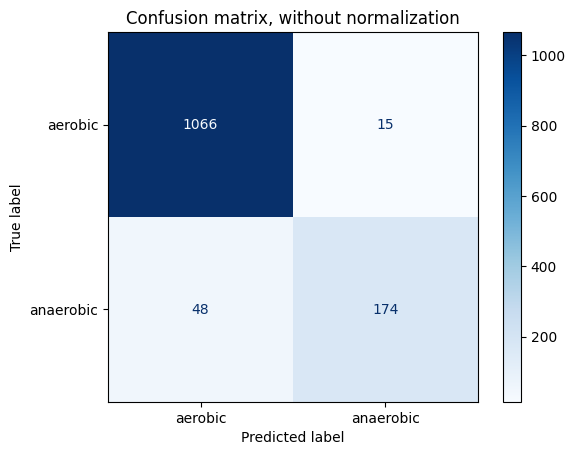

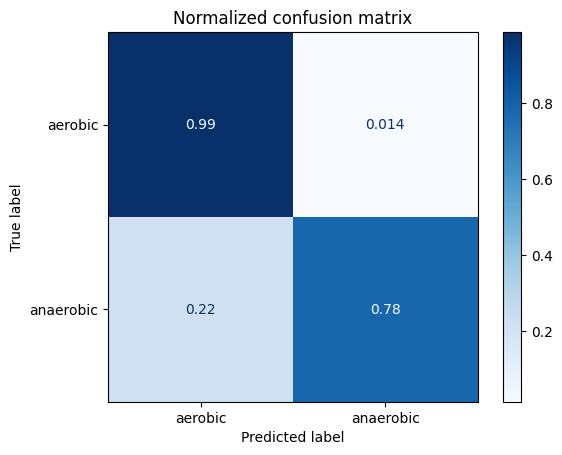

In [10]:
# Confusion Matrix Display
titles_options = [
    ("Confusion matrix, without normalization", None),
    ("Normalized confusion matrix", "true"),
]
for title, normalize in titles_options:
    disp = ConfusionMatrixDisplay.from_estimator(
        clf_best,
        X_test,
        Y_test,
        cmap=plt.cm.Blues,
        normalize=normalize,
    )
    disp.ax_.set_title(title)
    print(title)
    print(disp.confusion_matrix)

plt.show()